# Universal Spectra Analysis from JETSCAPE MAP Parameters

This notebook computes pT-differential spectra and universal scaled spectra from JETSCAPE (Pb-Pb collisions at 2.76 TeV) using MAP parameters with Chapman-Enskog corrections. 

## **Author:** OptimusThi  
## **Date:** December 2025

### 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

from calculations_file_format_single_event import (
    return_result_dtype, 
    Qn_species, 
    Qn_diff_pT_cuts
)

# For better plots in Jupyter
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using idf = 0 : Grad
SystemsInfo = 
{'Pb-Pb-2760': {'proj': 'Pb', 'targ': 'Pb', 'sqrts': 2760, 'run_id': 'production_500pts_Pb_Pb_2760', 'n_design': 500, 'n_validation': 100, 'design_remove_idx': [289, 483, 324, 326, 459, 429, 334, 462, 242, 341, 406, 440, 377, 123, 447], 'npc': 10, 'MAP_obs_file': 'main.dat'}}


### 2. Configuration

In [2]:
# Physical constants
MASS_LIST = np.array([0.13957, 0.49368, 0.93827, 1.18937, 1.32132])  # π, K, p, Σ, Ξ

# pT bins
PT_CUTS = np.array([
    0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6,
    0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25,
    1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9,
    1.95, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.2, 3.4,
    3.6, 3.8, 4.0, 10.0
])
PT_LIST = (PT_CUTS[1:] + PT_CUTS[:-1]) / 2

# Particles
PARTICLES = {
    'pi': {'id': 0, 'label': r'$\pi$', 'name': 'pion'},
    'ka': {'id': 1, 'label': r'$K$', 'name': 'kaon'},
    'pr': {'id': 2, 'label': r'$p$', 'name': 'proton'},
    'Sigma': {'id': 3, 'label': r'$\Sigma$', 'name': 'Sigma'},
    'Xi': {'id': 4, 'label': r'$\Xi$', 'name': 'Xi'}
}
PARTICLE_ORDER = ['pi', 'ka', 'pr', 'Sigma', 'Xi']

# Centrality bins
CENTRALITY_BINS = [(0, 5), (5, 10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 60)]
CENTRALITY_LABELS = ['0-5%', '5-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%']

# Delta-f correction (1 = Chapman-Enskog)
DELTA_F_INDEX = 1

# Plot styling
COLORS = ['red', 'black', 'blue', 'green', 'orange', 'cyan', 'gray']
MARKERS = ['o', '^', 's', 'v', 'd', 'H', '*']

print(f"Configuration loaded:")
print(f"  - {len(PARTICLES)} particle species")
print(f"  - {len(PT_LIST)} pT bins from {PT_CUTS[0]:.2f} to {PT_CUTS[-1]:.2f} GeV/c")
print(f"  - {len(CENTRALITY_BINS)} centrality bins")

Configuration loaded:
  - 5 particle species
  - 56 pT bins from 0.00 to 10.00 GeV/c
  - 7 centrality bins


### 3. Helper Functions

In [3]:
def configure_matplotlib_style():
    """Set matplotlib parameters for publication-quality plots."""
    params = {
        'xtick.major.size': 6, 'ytick.major.size': 6,
        'xtick.minor.size': 3, 'ytick.minor.size': 3,
        'xtick.major.width': 1.2, 'ytick.major.width': 1.2,
        'xtick.minor.width': 1.0, 'ytick.minor.width': 1.0,
        'axes.linewidth': 1.0, 'lines.linewidth': 1.0,
        'xtick.direction': 'in', 'ytick.direction': 'in',
        'xtick.minor.visible': True, 'ytick.minor.visible': True,
        'font.family': 'serif', 'font.size': 12
    }
    plt.rcParams.update(params)

configure_matplotlib_style()


def get_Q_0(alldata, delta_f_index, pid):
    """Extract Q_0 values (pT spectrum) for a specific particle type."""
    return np.array([event[4][delta_f_index][pid][0] for event in alldata])

def get_nsamples(alldata, delta_f_index):
    """Extract number of samples per hydro event."""
    nsamples = np.array([event[3][delta_f_index][0] for event in alldata], dtype=float)
    nsamples[nsamples == 0] = np.inf
    return nsamples

def sort_by_charged_multiplicity(Qn_norm, n_charged_species=3):
    """Sort events by charged particle multiplicity (descending)."""
    if Qn_norm.ndim == 4:
        charged_mult = 2.0 * np.sum(Qn_norm[:, :n_charged_species, 0, :], axis=(1, 2))
    elif Qn_norm.ndim == 3:
        charged_mult = 2.0 * np.sum(Qn_norm[:, :n_charged_species, :], axis=(1, 2))
    else:
        raise ValueError(f"Expected 3D or 4D array, got {Qn_norm.ndim}D")
    return np.argsort(charged_mult)[::-1]

def select_centrality_groups(eventlist, centrality_bins):
    """Group events into centrality percentile bins."""
    n_events = len(eventlist)
    groups = []
    for low_pct, high_pct in centrality_bins:
        idx_low = int(np.floor(low_pct / 100.0 * n_events))
        idx_high = int(np.floor(high_pct / 100.0 * n_events))
        groups.append(eventlist[idx_low:idx_high])
    return groups

def compute_universal_spectra(dNdpt_cent, pt_bins):
    """
    Compute universal scaling function U(x_T) for a centrality class.
    
    Returns
    -------
    mean_pT : float
        Mean transverse momentum <pT> (GeV/c)
    N : float
        Total multiplicity
    U : np.ndarray
        Universal spectrum U(x_T)
    mean_spectrum : np.ndarray
        Average dN/dpT spectrum
    """
    mean_spectrum = np.mean(dNdpt_cent, axis=0)
    N = np.trapz(mean_spectrum, pt_bins)
    mean_pT = np.trapz(pt_bins * mean_spectrum, pt_bins) / N
    U = mean_pT * mean_spectrum / N
    return mean_pT, N, U, mean_spectrum

print("Helper functions defined ✓")

Helper functions defined ✓


### 4. Load JETSCAPE Data

In [4]:
# Load data
data_file = 'results_recalc_MAP_CE_Pb_2760_fine_pT.dat'
print(f"Loading data from: {data_file}")

result_dtype = return_result_dtype('ALICE')
data = np.fromfile(data_file, dtype=result_dtype)

print(f"✓ Loaded {len(data)} events")

# Get normalization samples
samples = get_nsamples(data, DELTA_F_INDEX)
print(f"✓ Extracted normalization samples")

Loading data from: results_recalc_MAP_CE_Pb_2760_fine_pT.dat


/tmp/ipykernel_10429/2501618078.py:6: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(data_file, dtype=result_dtype)


✓ Loaded 5040 events
✓ Extracted normalization samples


### 5. Process Particle Spectra

In [5]:
print("Processing particle spectra...")

# Extract and normalize spectra for all particles
Qn_norm_all = np.zeros((len(data), len(PARTICLES), len(PT_LIST)))

for particle_name, info in PARTICLES.items():
    pid = info['id']
    Q_0 = get_Q_0(data, DELTA_F_INDEX, pid)
    Qn_norm_all[:, pid, :] = Q_0 / samples[:, np.newaxis] / np.diff(PT_CUTS)
    print(f"  ✓ {info['name']:8s} (pid={pid})")

print("✓ All spectra processed")

Processing particle spectra...
  ✓ pion     (pid=0)
  ✓ kaon     (pid=1)
  ✓ proton   (pid=2)
  ✓ Sigma    (pid=3)
  ✓ Xi       (pid=4)
✓ All spectra processed


### 6. Sort by Centrality

In [6]:
print("Sorting events by charged multiplicity...")
eventlist = sort_by_charged_multiplicity(Qn_norm_all)
cent_groups = select_centrality_groups(eventlist, CENTRALITY_BINS)

print(f"✓ Events sorted into {len(cent_groups)} centrality bins:")
for i, (cent_bin, events) in enumerate(zip(CENTRALITY_BINS, cent_groups)):
    print(f"  {CENTRALITY_LABELS[i]:8s}: {len(events):5d} events")

Sorting events by charged multiplicity...
✓ Events sorted into 7 centrality bins:
  0-5%    :   252 events
  5-10%   :   252 events
  10-20%  :   504 events
  20-30%  :   504 events
  30-40%  :   504 events
  40-50%  :   504 events
  50-60%  :   504 events


### 7. Compute Universal Spectra for All Particles and Centralities

In [7]:
print("Computing universal spectra...")

# Initialize storage dictionaries
results = {
    'differential_spectra': {},  # dN/dpT
    'universal_spectra': {},     # U(x_T)
    'mean_pt': {},               # <pT>
    'multiplicity': {},          # N
    'x_T': {}                    # x_T = pT/<pT>
}

for particle_name in PARTICLE_ORDER:
    pid = PARTICLES[particle_name]['id']
    dNdpt = Qn_norm_all[:, pid, :]
    
    # Initialize arrays for this particle
    n_cent = len(cent_groups)
    n_pt = len(PT_LIST)
    
    results['differential_spectra'][particle_name] = np.zeros((n_cent, n_pt))
    results['universal_spectra'][particle_name] = np.zeros((n_cent, n_pt))
    results['mean_pt'][particle_name] = np.zeros(n_cent)
    results['multiplicity'][particle_name] = np.zeros(n_cent)
    results['x_T'][particle_name] = np.zeros((n_cent, n_pt))
    
    # Compute for each centrality
    for cent_idx, event_indices in enumerate(cent_groups):
        if len(event_indices) == 0:
            print(f"  Warning: No events in centrality {CENTRALITY_LABELS[cent_idx]}, {particle_name}")
            continue
        
        dNdpt_cent = dNdpt[event_indices]
        mean_pT, N, U, mean_spectrum = compute_universal_spectra(dNdpt_cent, PT_LIST)
        
        # Store results
        results['differential_spectra'][particle_name][cent_idx] = mean_spectrum
        results['universal_spectra'][particle_name][cent_idx] = U
        results['mean_pt'][particle_name][cent_idx] = mean_pT
        results['multiplicity'][particle_name][cent_idx] = N
        results['x_T'][particle_name][cent_idx] = PT_LIST / mean_pT
    
    print(f"  ✓ {PARTICLES[particle_name]['name']}")

print("✓ Universal spectra computed for all particles and centralities")

Computing universal spectra...
  ✓ pion
  ✓ kaon
  ✓ proton
  ✓ Sigma
  ✓ Xi
✓ Universal spectra computed for all particles and centralities


### 8. Save Results to NPZ File

In [8]:
# Create output directory
output_dir = Path('output')
output_dir.mkdir(exist_ok=True)

# Prepare data for saving
save_dict = {
    # Metadata
    'metadata/date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metadata/n_events': len(data),
    'metadata/delta_f_index': DELTA_F_INDEX,
    'metadata/collision_system': 'Pb-Pb @ 2.76 TeV',
    'metadata/model': 'JETSCAPE MAP Chapman-Enskog',
    
    # Configuration
    'config/pt_cuts': PT_CUTS,
    'config/pt_list': PT_LIST,
    'config/centrality_bins': np.array(CENTRALITY_BINS),
    'config/centrality_labels': np.array(CENTRALITY_LABELS),
    'config/particle_order': np.array(PARTICLE_ORDER),
    'config/mass_list': MASS_LIST,
}

# Add particle data
for particle_name in PARTICLE_ORDER:
    prefix = f'particle/{particle_name}'
    save_dict[f'{prefix}/differential_spectra'] = results['differential_spectra'][particle_name]
    save_dict[f'{prefix}/universal_spectra'] = results['universal_spectra'][particle_name]
    save_dict[f'{prefix}/mean_pt'] = results['mean_pt'][particle_name]
    save_dict[f'{prefix}/multiplicity'] = results['multiplicity'][particle_name]
    save_dict[f'{prefix}/x_T'] = results['x_T'][particle_name]
    save_dict[f'{prefix}/label'] = PARTICLES[particle_name]['label']
    save_dict[f'{prefix}/full_name'] = PARTICLES[particle_name]['name']

# Save to NPZ file
output_file = output_dir / 'universal_spectra_results.npz'
np.savez_compressed(output_file, **save_dict)

print(f"✓ Results saved to: {output_file}")
print(f"  File size: {output_file.stat().st_size / 1024:.2f} KB")

✓ Results saved to: output/universal_spectra_results.npz
  File size: 52.94 KB


### 9. Verify Saved Data (Optional)

In [9]:
# Load and verify
loaded = np.load(output_file, allow_pickle=True)

print("Saved data structure:")
print("-" * 60)
for key in sorted(loaded.keys()):
    data_shape = loaded[key].shape if hasattr(loaded[key], 'shape') else 'scalar'
    data_type = loaded[key].dtype
    print(f"  {key:50s} {str(data_shape):15s} {data_type}")

print(f"\n✓ Total keys saved: {len(loaded.keys())}")

Saved data structure:
------------------------------------------------------------
  config/centrality_bins                             (7, 2)          int64
  config/centrality_labels                           (7,)            <U6
  config/mass_list                                   (5,)            float64
  config/particle_order                              (5,)            <U5
  config/pt_cuts                                     (57,)           float64
  config/pt_list                                     (56,)           float64
  metadata/collision_system                          ()              <U16
  metadata/date                                      ()              <U19
  metadata/delta_f_index                             ()              int64
  metadata/model                                     ()              <U27
  metadata/n_events                                  ()              int64
  particle/Sigma/differential_spectra                (7, 56)         float64
  particle/Sigma

### 10. Create Plots

✓ Saved: output/spectra_pi.png


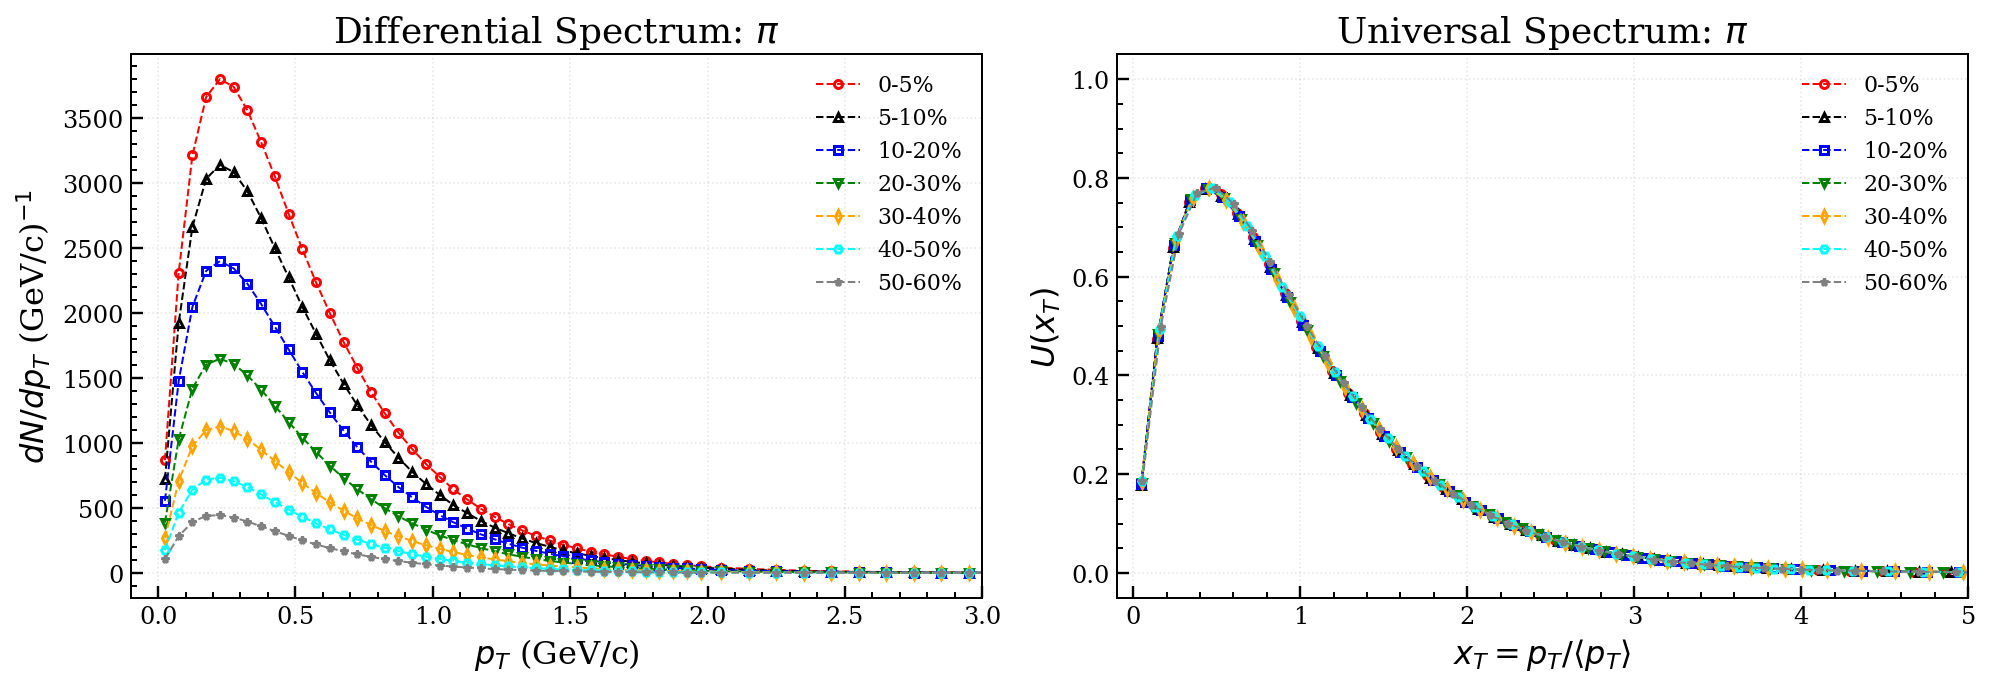

✓ Saved: output/spectra_ka.png


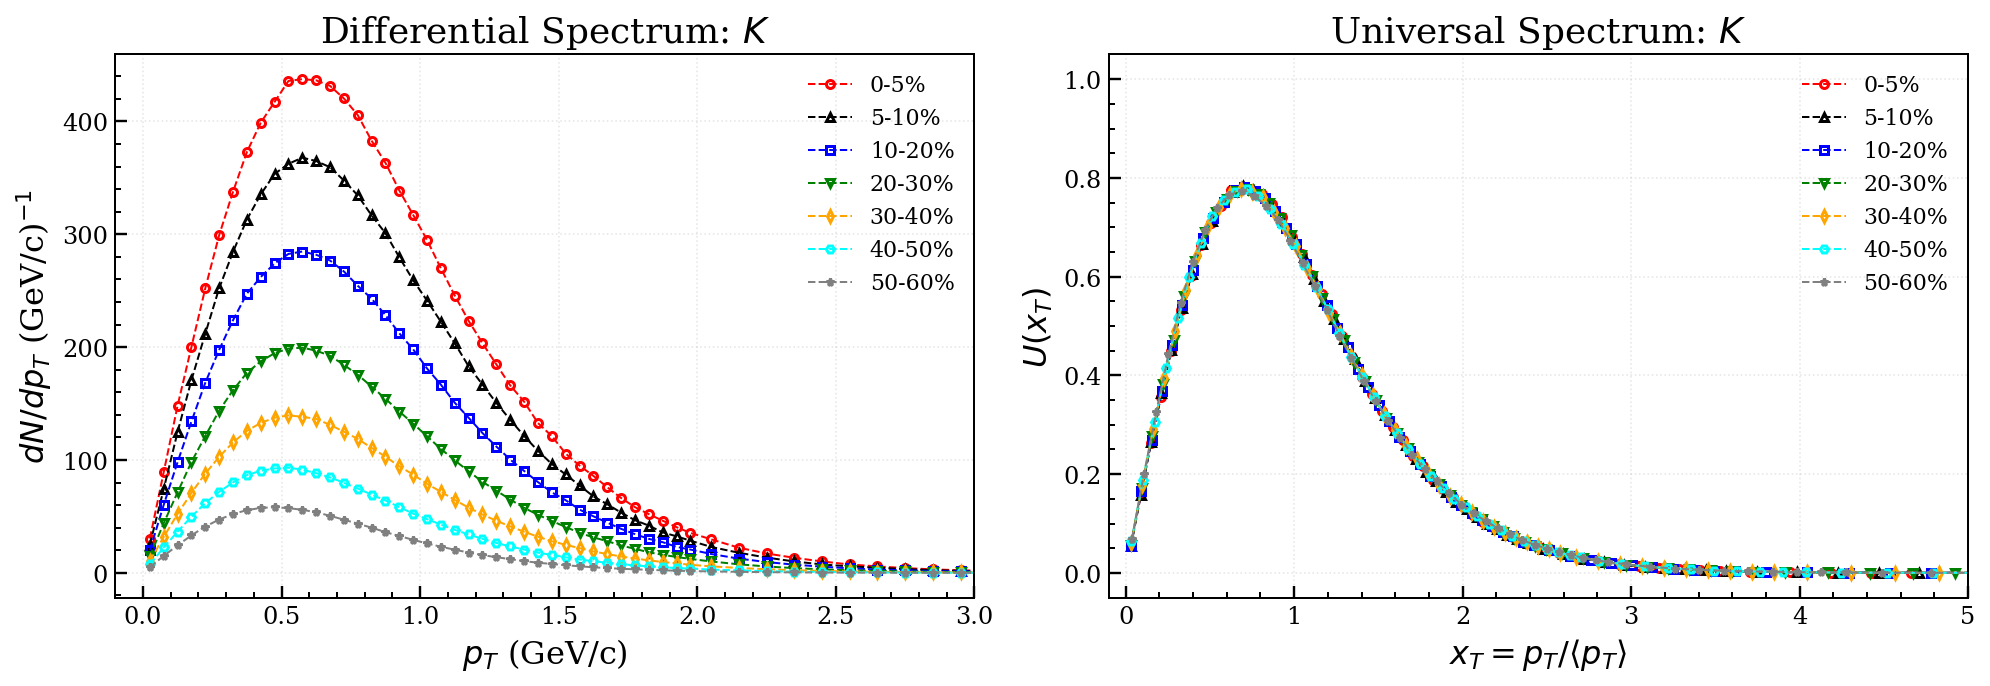

✓ Saved: output/spectra_pr.png


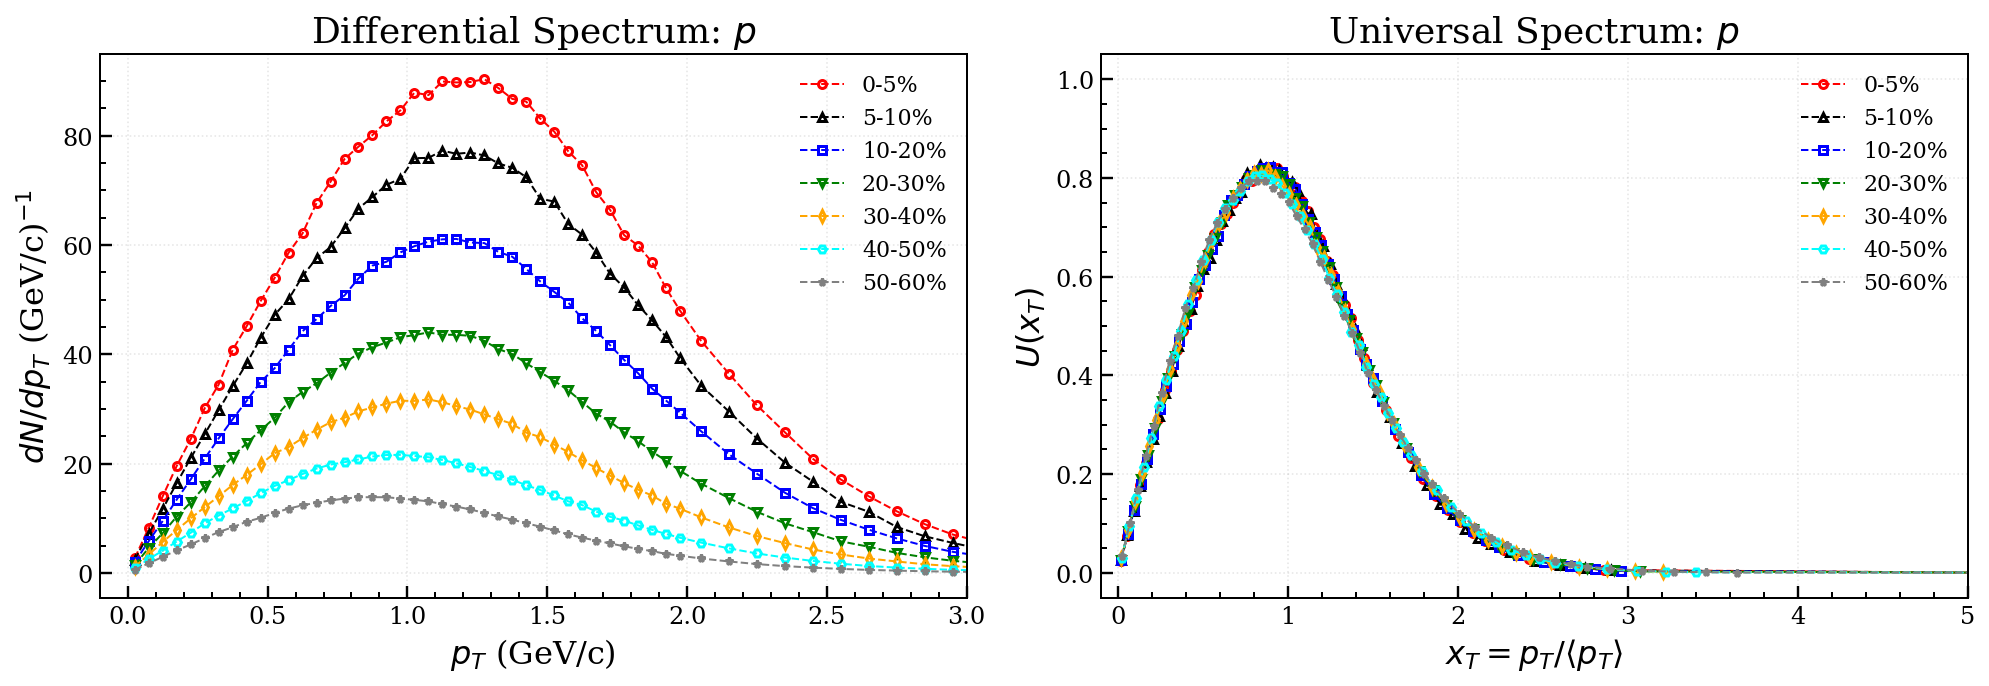

✓ Saved: output/spectra_Sigma.png


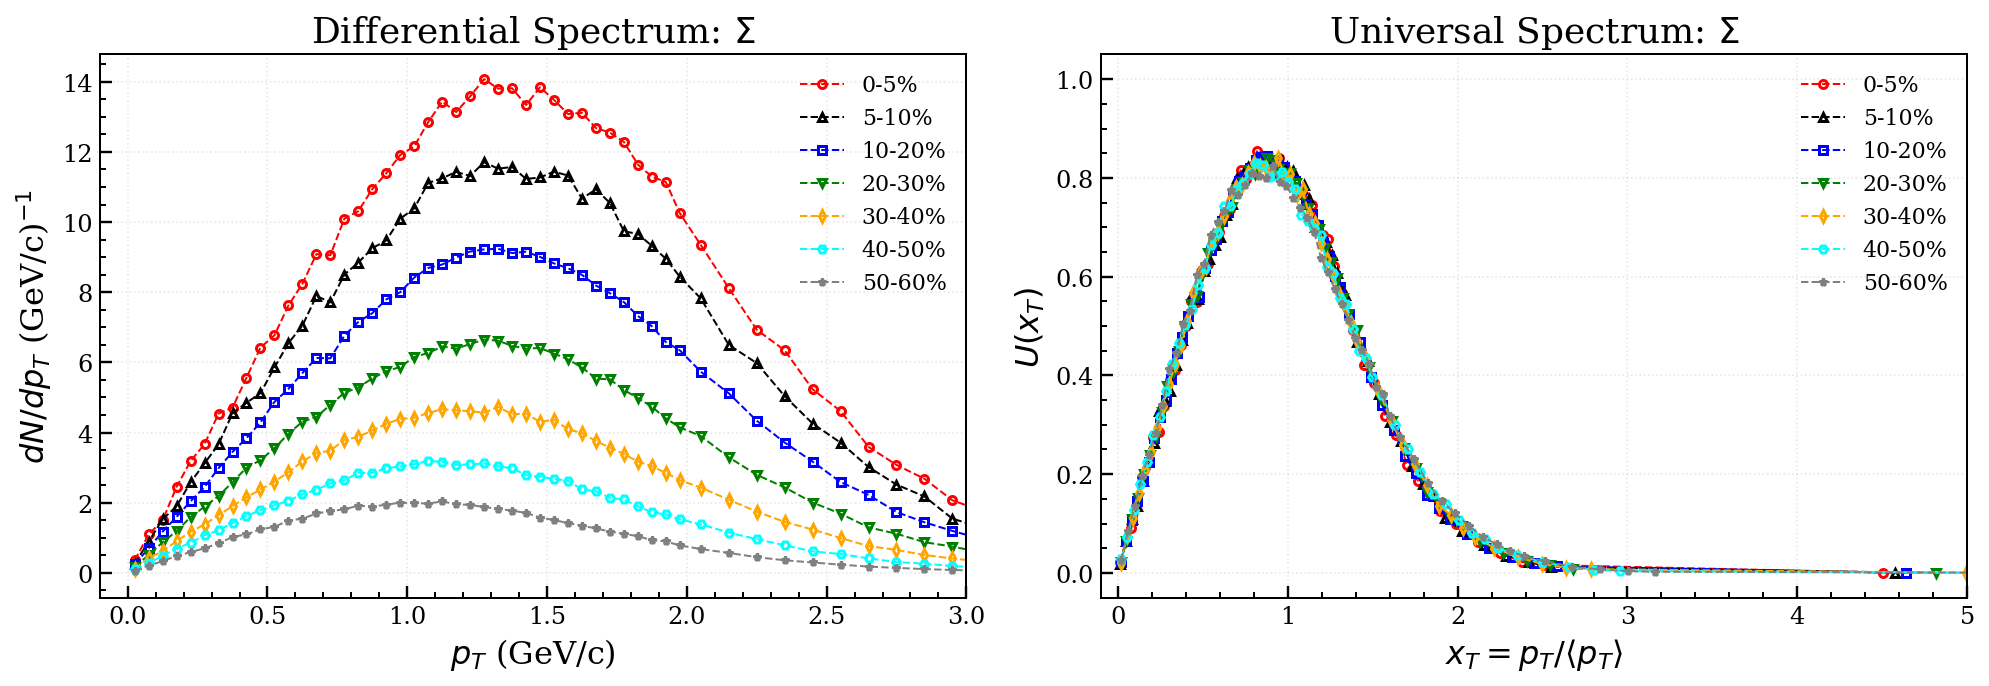

✓ Saved: output/spectra_Xi.png


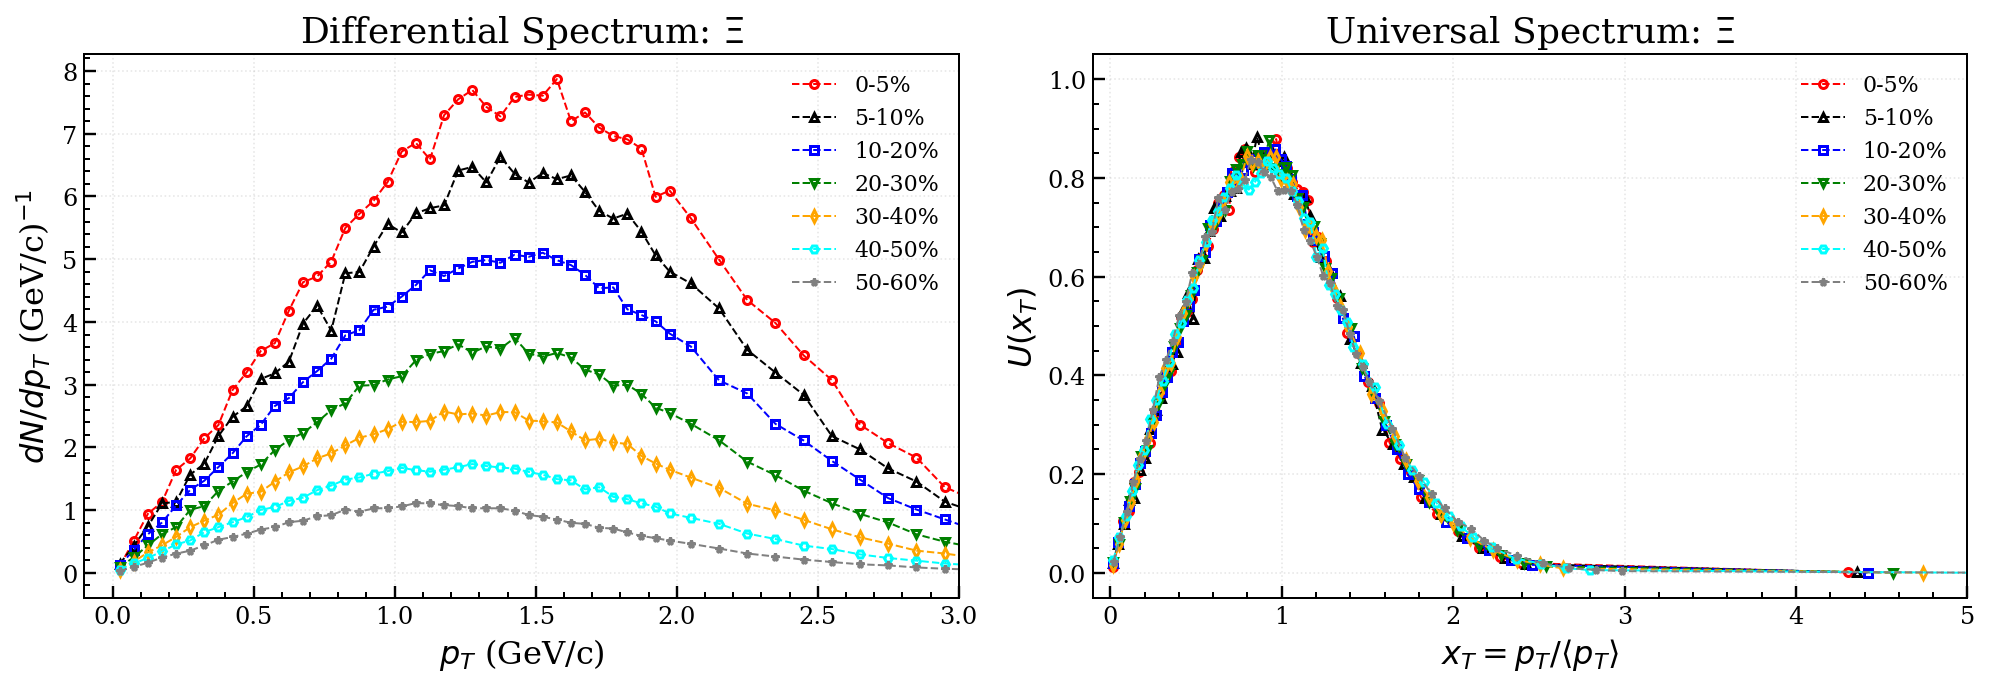

In [10]:
def plot_single_particle(particle_name, results, pt_list, 
                        centrality_labels, colors, markers, fontsize=16):
    """Create a two-panel plot for a single particle species."""
    fig, (ax_diff, ax_univ) = plt.subplots(1, 2, figsize=(14, 5))
    
    particle_label = PARTICLES[particle_name]['label']
    n_cent = len(centrality_labels)
    
    for cent_idx in range(n_cent):
        # Differential spectrum
        spectrum = results['differential_spectra'][particle_name][cent_idx]
        ax_diff.plot(pt_list, spectrum,
                    color=colors[cent_idx], linestyle='--',
                    marker=markers[cent_idx], markersize=4,
                    markerfacecolor='none', markeredgewidth=1.5,
                    label=centrality_labels[cent_idx])
        
        # Universal spectrum
        x_T = results['x_T'][particle_name][cent_idx]
        U = results['universal_spectra'][particle_name][cent_idx]
        ax_univ.plot(x_T, U,
                    color=colors[cent_idx], linestyle='--',
                    marker=markers[cent_idx], markersize=4,
                    markerfacecolor='none', markeredgewidth=1.5,
                    label=centrality_labels[cent_idx])
    
    # Configure left panel (differential)
    ax_diff.set_xlabel(r'$p_T$ (GeV/c)', fontsize=fontsize)
    ax_diff.set_ylabel(r'$dN/dp_T$ (GeV/c)$^{-1}$', fontsize=fontsize)
    ax_diff.set_xlim(-0.1, 3.0)
    ax_diff.set_title(f'Differential Spectrum: {particle_label}', fontsize=fontsize+2)
    ax_diff.legend(loc='best', frameon=False, fontsize=11)
    ax_diff.grid(alpha=0.3, linestyle=':')
    
    # Configure right panel (universal)
    ax_univ.set_xlabel(r'$x_T = p_T / \langle p_T \rangle$', fontsize=fontsize)
    ax_univ.set_ylabel(r'$U(x_T)$', fontsize=fontsize)
    ax_univ.set_xlim(-0.1, 5.0)
    ax_univ.set_ylim(-0.05, 1.05)
    ax_univ.set_title(f'Universal Spectrum: {particle_label}', fontsize=fontsize+2)
    ax_univ.legend(loc='best', frameon=False, fontsize=11)
    ax_univ.grid(alpha=0.3, linestyle=':')
    
    plt.tight_layout()
    return fig

# Create individual plots for each particle
for particle_name in PARTICLE_ORDER:
    fig = plot_single_particle(particle_name, results, PT_LIST,
                               CENTRALITY_LABELS, COLORS, MARKERS)
    
    # Save figure
    fig_file = output_dir / f'spectra_{particle_name}.png'
    fig.savefig(fig_file, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {fig_file}")
    
    plt.show()

### 11. Create Combined Multi-Panel Plot


✓ Saved combined plot: output/universal_spectra_combined.png


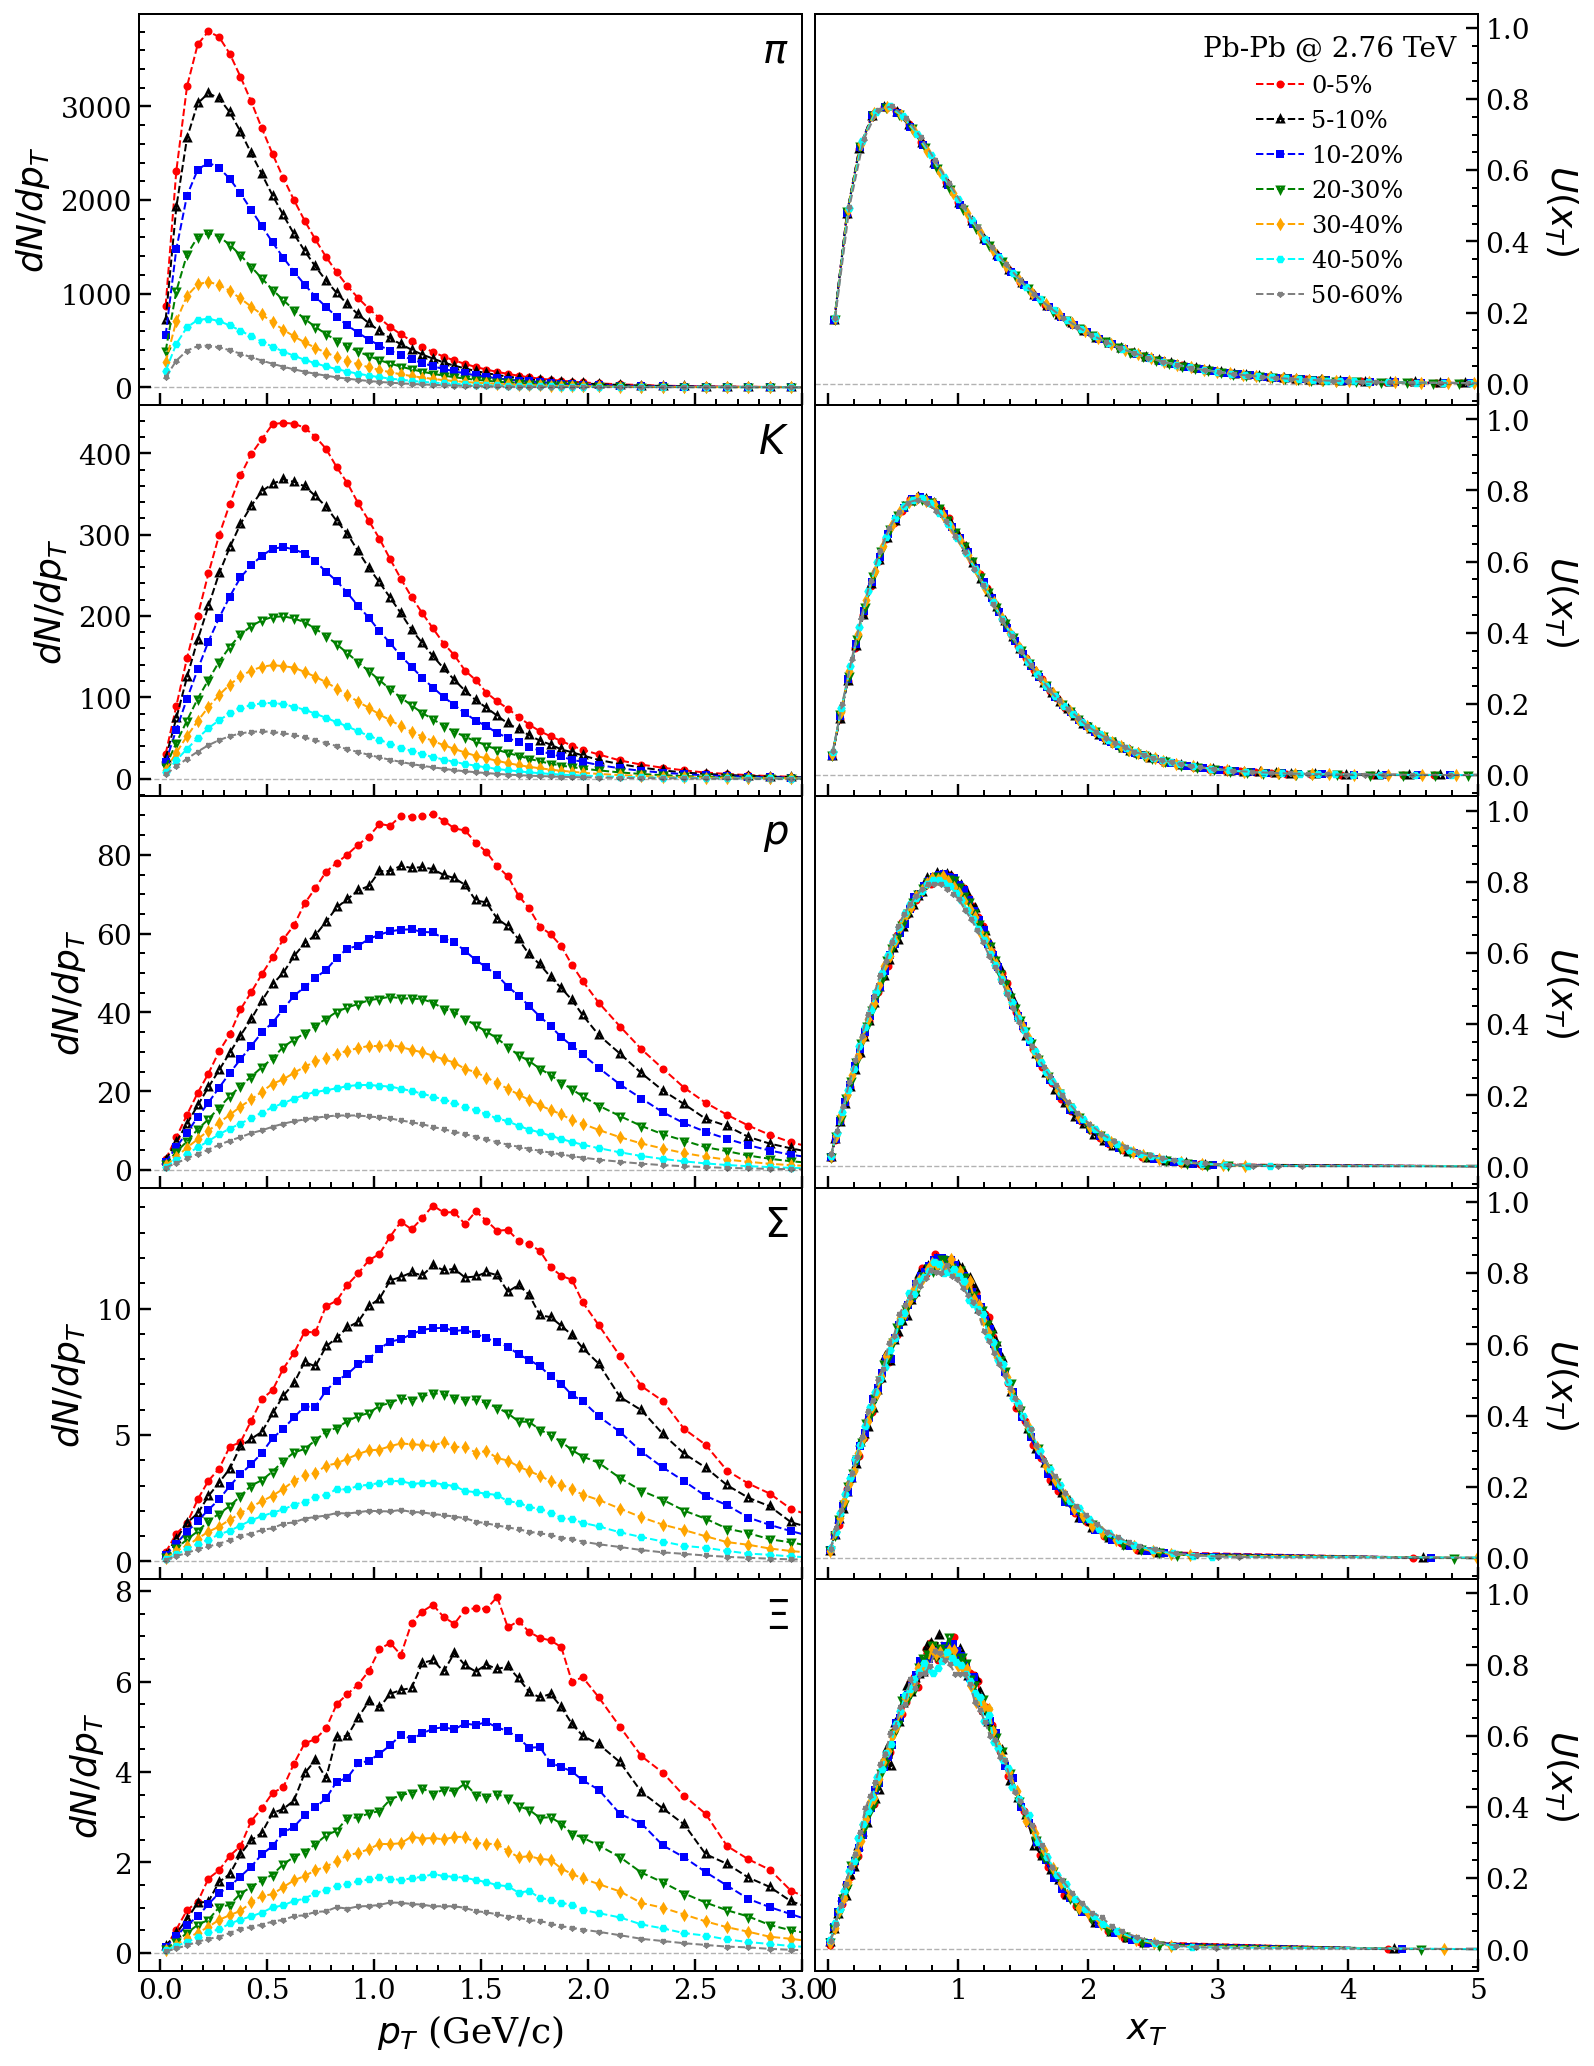

In [11]:
def plot_all_particles_combined(results, pt_list, particle_order, particles_info,
                               centrality_labels, colors, markers, fontsize=18):
    """Create the full 5x2 comparison plot."""
    n_particles = len(particle_order)
    fig, axes = plt.subplots(n_particles, 2, figsize=(12, 18), 
                             sharey=False, sharex='col')
    
    for row, particle_name in enumerate(particle_order):
        particle_label = particles_info[particle_name]['label']
        ax_diff = axes[row, 0]
        ax_univ = axes[row, 1]
        
        # Plot each centrality
        for cent_idx in range(len(centrality_labels)):
            # Differential spectrum
            spectrum = results['differential_spectra'][particle_name][cent_idx]
            ax_diff.plot(pt_list, spectrum,
                        color=colors[cent_idx], linestyle='--',
                        marker=markers[cent_idx], markersize=2,
                        markerfacecolor='none', markeredgewidth=2)
            
            # Universal spectrum
            x_T = results['x_T'][particle_name][cent_idx]
            U = results['universal_spectra'][particle_name][cent_idx]
            ax_univ.plot(x_T, U,
                        color=colors[cent_idx], linestyle='--',
                        marker=markers[cent_idx], markersize=2,
                        markerfacecolor='none', markeredgewidth=2,
                        label=centrality_labels[cent_idx])
        
        # Configure axes
        ax_diff.set_xlim(-0.1, 3.0)
        ax_univ.set_xlim(-0.1, 5.0)
        ax_univ.set_ylim(-0.06, 1.04)
        
        # Legends (top row only)
        if row == 0:
            ax_univ.legend(loc='best', frameon=False, fontsize=12,
                          title='Pb-Pb @ 2.76 TeV', title_fontsize=14,
                          handletextpad=0.3, numpoints=1)
        
        # Labels
        if row == n_particles - 1:
            ax_diff.set_xlabel(r'$p_T$ (GeV/c)', fontsize=fontsize)
            ax_univ.set_xlabel(r'$x_T$', fontsize=fontsize)
        
        ax_diff.set_ylabel(r'$dN/dp_T$', fontsize=fontsize)
        ax_univ.yaxis.set_label_position("right")
        ax_univ.yaxis.tick_right()
        ax_univ.set_ylabel(r'$U(x_T)$', rotation=-90, fontsize=fontsize, labelpad=25)
        
        # Reference lines
        ax_diff.axhline(y=0, color='black', linestyle='--', linewidth=0.7, alpha=0.3)
        ax_univ.axhline(y=0, color='black', linestyle='--', linewidth=0.7, alpha=0.3)
        
        # Particle label
        ax_diff.text(0.98, 0.95, particle_label, fontsize=fontsize+2,
                    transform=ax_diff.transAxes, va='top', ha='right')
        
        # Tick parameters
        ax_diff.tick_params(labelsize=14)
        ax_univ.tick_params(labelsize=14)
    
    plt.subplots_adjust(wspace=0.02, hspace=0)
    return fig

# Create combined plot
fig_combined = plot_all_particles_combined(results, PT_LIST, PARTICLE_ORDER, 
                                           PARTICLES, CENTRALITY_LABELS, 
                                           COLORS, MARKERS)

# Save combined figure
combined_file = output_dir / 'universal_spectra_combined.png'
fig_combined.savefig(combined_file, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved combined plot: {combined_file}")

plt.show()

### 12. Summary Statistics

In [12]:
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)

for particle_name in PARTICLE_ORDER:
    print(f"\n{PARTICLES[particle_name]['name'].upper()} ({PARTICLES[particle_name]['label']})")
    print("-" * 70)
    print(f"{'Centrality':<15} {'<pT> (GeV/c)':<15} {'N (mult.)':<15} {'U_max':<15}")
    print("-" * 70)
    
    for cent_idx, cent_label in enumerate(CENTRALITY_LABELS):
        mean_pt = results['mean_pt'][particle_name][cent_idx]
        mult = results['multiplicity'][particle_name][cent_idx]
        u_max = np.max(results['universal_spectra'][particle_name][cent_idx])
        print(f"{cent_label:<15} {mean_pt:<15.4f} {mult:<15.2f} {u_max:<15.4f}")

print("\n" + "="*70)
print("✓ Analysis complete!")
print("="*70)


SUMMARY STATISTICS

PION ($\pi$)
----------------------------------------------------------------------
Centrality      <pT> (GeV/c)    N (mult.)       U_max          
----------------------------------------------------------------------
0-5%            0.5241          2558.91         0.7785         
5-10%           0.5207          2102.38         0.7781         
10-20%          0.5156          1588.91         0.7786         
20-30%          0.5052          1071.43         0.7771         
30-40%          0.4932          713.53          0.7789         
40-50%          0.4758          447.06          0.7795         
50-60%          0.4568          260.54          0.7801         

KAON ($K$)
----------------------------------------------------------------------
Centrality      <pT> (GeV/c)    N (mult.)       U_max          
----------------------------------------------------------------------
0-5%            0.8366          470.28          0.7782         
5-10%           0.8279        

### 13. Example: Load and Use Saved Data

In [13]:
# Example of how to load and use the saved data in a new session
print("Example: Loading saved data...")

loaded_data = np.load('output/universal_spectra_results.npz', allow_pickle=True)

# Access metadata
print(f"\nMetadata:")
print(f"  Date: {loaded_data['metadata/date']}")
print(f"  Events: {loaded_data['metadata/n_events']}")
print(f"  System: {loaded_data['metadata/collision_system']}")

# Access configuration
pt_bins = loaded_data['config/pt_list']
centrality_bins = loaded_data['config/centrality_bins']

print(f"\nConfiguration:")
print(f"  pT bins: {len(pt_bins)} from {pt_bins[0]:.2f} to {pt_bins[-1]:.2f} GeV/c")
print(f"  Centrality bins: {len(centrality_bins)}")

# Access specific particle data
particle = 'pi'
pi_mean_pt = loaded_data[f'particle/{particle}/mean_pt']
pi_spectrum = loaded_data[f'particle/{particle}/differential_spectra']

print(f"\nPion data:")
print(f"  Mean pT shape: {pi_mean_pt.shape}")
print(f"  Spectrum shape: {pi_spectrum.shape}")
print(f"  Mean pT values: {pi_mean_pt}")

print("\n✓ Data successfully loaded and accessed!")

Example: Loading saved data...

Metadata:
  Date: 2025-12-14 22:57:34
  Events: 5040
  System: Pb-Pb @ 2.76 TeV

Configuration:
  pT bins: 56 from 0.03 to 7.00 GeV/c
  Centrality bins: 7

Pion data:
  Mean pT shape: (7,)
  Spectrum shape: (7, 56)
  Mean pT values: [0.52410159 0.52071689 0.51560158 0.50516576 0.49315652 0.47580004
 0.45675872]

✓ Data successfully loaded and accessed!
